Device = cpu
M tensor([1.0000, 1.0000])
max real lam2(W) 0.5029401183128357
Time to generate x(t): 7.142457008361816 s
torch.Size([1, 1000000, 500])
torch.Size([1, 1000000, 500])


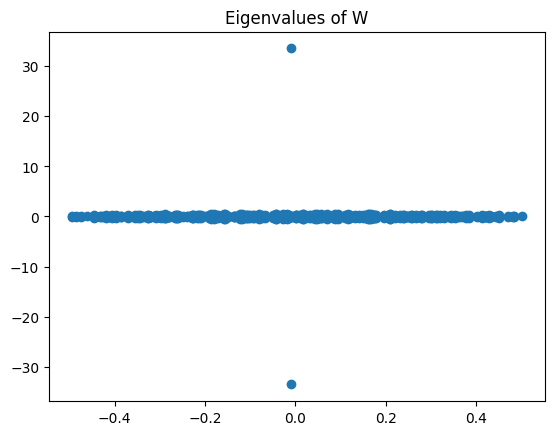

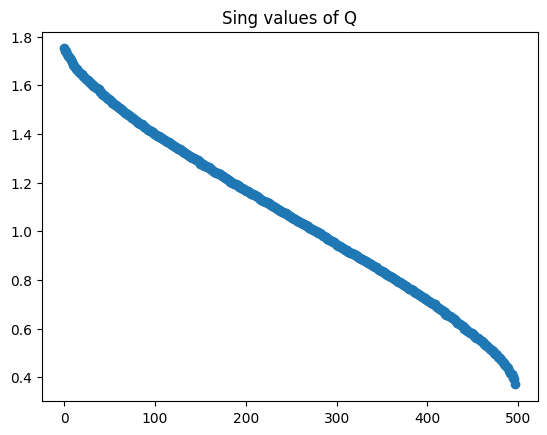

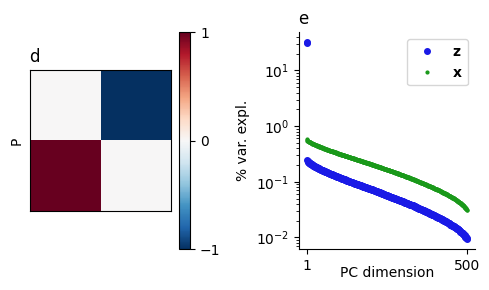

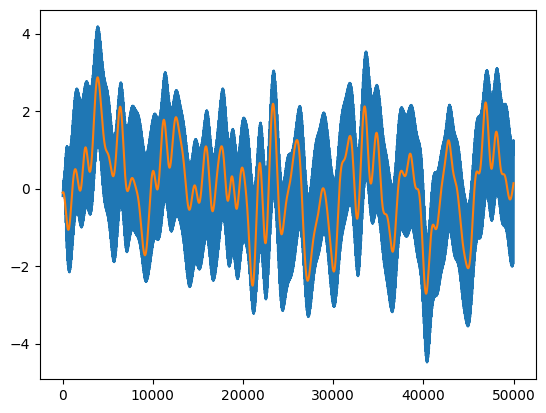

In [1]:
# ROTATE NORMAL, SYMMETRIC EXAMPLE TO GET NORMAL NON-SYMMETRIC 
# ALSO NEED TO IMPOSE REPEATED SING VALUES

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm


import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True


device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)


####### Set parameter values

# Number of neurons in recurrent net
N = 500

# Parameters
rho=0.5

# Time step size, timescale of dynamics
dt = 0.01
tau=1

# Simulation time
T=10000

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


###### Generate variables 

time=np.arange(0,T,dt)
Nt=len(time)

eta = dt/tau

# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)


# Low rank part
sigmas = np.sqrt(N)*torch.tensor([1.5,1.5])
Sigma = torch.diag(sigmas)

# Generate 4 orthonormal vectors
OrthVecs = GetOrthonormalVectors(N,4)


### Sim 2: EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[0,:]
# V[:,1] = OrthVecs[1,:]

# Rotation matrix P
theta=torch.tensor(torch.pi/2)
R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
              [torch.sin(theta),  torch.cos(theta)]])

# # Construct V
V = -U @ R.T


W0 = U@Sigma@V.T
W = W0+W1

P2 = U.T@V

L,M,RT=torch.linalg.svd(P2)
R=RT.T
print('M',M)


# ### Sim 2: EP matrix
# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[1,:]
# V[:,1] = -OrthVecs[0,:]
# W0 = U@Sigma@V.T
# W = W0+W1
# P2 = U.T@V


# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = -OrthVecs[0,:]
# V[:,1] = -OrthVecs[1,:]
# W0 = U@Sigma@V.T
# W = W0+W1


lamW2 = torch.linalg.eigvals(W.cpu())
print('max real lam2(W)',torch.real(lamW2).max().item())


plt.figure()
plt.plot(np.real(lamW2),np.imag(lamW2),'o')
plt.title('Eigenvalues of W')

Q=torch.eye(N)-W
UQ,SQ,VQT=torch.linalg.svd(Q)
VQ=VQT.T

plt.figure()
plt.plot(SQ[2:],'o')
plt.title('Sing values of Q')


# Generate Gaussian noise
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt,dt,N,device=device).T
    x = x[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')

# Compute PCA of stimulus, x
with torch.no_grad():   
    Ux,Sx=TorchPCA(x[0,:,:], scaled=False)

model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    #print('Time for  sim:',tsim,'s')
    Uz12,Sz2=TorchPCA(z[0,:,:], scaled=False)

#####  Make figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N

fig, axes = plt.subplot_mosaic("de",figsize=(5,3))

#axes['x'].axis('off')
#axes['x'].text(.25,.4,'something\nhere?',color=(.5,.5,.5))
# axes['x'].set_title('x',loc='left')

# ####### PANEL A ######
# c0='a'
# ax0 = axes[c0]
# ax0.axis('off')
# #plt.rcParams['text.usetex'] = True
# ax0.text(.5,.5,r'$W_0=USV^T$')
# ax0.text(.5,0,r'$P=U^TV$')
# ax0.set_title(c0,loc='left')


# ####### PANEL B ######
# c0='b'
# ax0 = axes[c0]
# #ax0.plot(np.arange(N)+1,100*Sz1/Sz1.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
# ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
# ax0.set_xscale('linear')
# ax0.set_yscale('log')
# #ax0.set_xlabel('PC dim.')
# ax0.set_xticks([1, 50, 100])
# #ax0.set_yticks([10, 100])
# ax0.set_ylabel('% var. expl.')
# ax0.legend()
# ax0.set_title(c0,loc='left')
# sns.despine(ax=ax0)

# Define functions for plotting P matrix and plotting PCA for z
def PPlot(P,c0):
    ax0 = axes[c0]
    im = ax0.imshow(P, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax0)
    cbar.set_ticks([-1,0,1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_ylabel('P')
    ax0.set_title(c0,loc='left')

def SzPlot(Sz,c0):
    ax0 = axes[c0]
    ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
    ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
    ax0.set_xscale('linear')
    ax0.set_yscale('log')
    #ax0.set_xlabel('PC dim.')
    ax0.set_xticks([1, N])
    #ax0.set_yticks([10, 100])
    ax0.set_ylabel('% var. expl.')
    #ax0.legend()
    ax0.set_title(c0,loc='left')
    sns.despine(ax=ax0)


PPlot(P2,'d')
SzPlot(Sz2,'e')
axes['e'].legend()
axes['e'].set_xlabel('PC dimension',labelpad=-5)

fig.tight_layout()

plt.figure()
print(z.shape)
print(x.shape)
Q=torch.eye(N)-W
A=torch.linalg.inv(Q)
tplot = 50000
iplot=15
plt.plot(z[0,:tplot,iplot])
plt.plot((A@x[0,:tplot,:].T)[iplot,:])